# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

import os, re, gc, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sn
import anndata
import scanpy as sc
import scvelo as scv
import sctk as sk
import cellrank as cr

rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42
expr_cmap = sk.expression_colormap()
np.set_printoptions(linewidth=150)

import numpy_groupies as npg
from plotnine import ggplot, aes
import plotnine as pln
from matplotlib.colors import ListedColormap

import matplotlib
import matplotlib.cm as cm

from statsmodels.stats.multitest import fdrcorrection

from scipy.stats import pearsonr, spearmanr

import scipy.sparse as sp

# Load data

## Fetal skin

In [5]:
myeloid_ad = sc.read(
    "../20210611_final_object/cellxgene_h5ad/20220202/fetal_skin.myeloid.cellxgene.20220202.h5ad"
)

Only considering the two last: ['.20220202', '.h5ad'].
Only considering the two last: ['.20220202', '.h5ad'].


In [6]:
myeloid_ad.obs.independent_annotation_refined_20220202.value_counts()

LYVE1++ macrophage                      20280
Monocyte                                 3044
DC2                                      2529
MHCII+ macrophage                        2196
Monocyte (activated/differentiating)     1895
Monocyte precursor                       1734
TREM2+ macrophage                        1617
DC1                                       748
LC                                        379
Iron-recycling macrophage                 299
Neutrophil2                               174
ASDC                                       90
Neutrophil1                                88
Inflammatory DC                            78
Name: independent_annotation_refined_20220202, dtype: int64

In [7]:
fetal_skin_ad = myeloid_ad[
    myeloid_ad.obs.independent_annotation_refined_20220202.isin(
        [
            "LYVE1++ macrophage",
            "MHCII+ macrophage",
            "Iron-recycling macrophage",
            "TREM2+ macrophage",
            "LC",
            "Monocyte precursor",
            "Monocyte (activated/differentiating)",
        ]
    )
].copy()

In [8]:
fetal_skin_ad.obs.independent_annotation_refined_20220202.value_counts()

LYVE1++ macrophage                      20280
MHCII+ macrophage                        2196
Monocyte (activated/differentiating)     1895
Monocyte precursor                       1734
TREM2+ macrophage                        1617
LC                                        379
Iron-recycling macrophage                 299
Name: independent_annotation_refined_20220202, dtype: int64

In [9]:
fetal_skin_ad

AnnData object with n_obs × n_vars = 28400 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'joint_annotation_20220202', 'independent_annotation_refined_20220202', 'fig1b_annotation_20220202'
    var: 'gene_ids', 'mito

In [10]:
fetal_skin_ad1 = sk.subsample(
    fetal_skin_ad, fraction=1, groupby="independent_annotation_refined_20220202", max_n=500
).copy()

In [11]:
fetal_skin_ad1

AnnData object with n_obs × n_vars = 3178 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'joint_annotation_20220202', 'independent_annotation_refined_20220202', 'fig1b_annotation_20220202'
    var: 'gene_ids', 'mito'

## Bian fetal macrophage

In [12]:
fetal_mac_X = pd.read_csv(
    "../data/GSE133345/GSE133345_Quality_controled_UMI_data_of_all_1231_embryonic_cells.txt.gz",
    sep=" ",
)

In [13]:
fetal_mac_X.shape

(26082, 1231)

In [14]:
fetal_mac_obs = pd.read_csv(
    "../data/GSE133345/GSE133345_Annotations_of_all_1231_embryonic_cells_updated_0620.txt.gz",
    sep=" ",
)

In [15]:
fetal_mac_ad = anndata.AnnData(
    X=sp.csr_matrix(fetal_mac_X.T.values, shape=fetal_mac_X.T.shape, dtype=np.float32),
    obs=fetal_mac_obs,
    var=pd.DataFrame(fetal_mac_X.index).set_index(0),
)

In [16]:
fetal_mac_ad.obsm["X_umap"] = fetal_mac_ad.obs[["UMAP1", "UMAP2"]].values

In [17]:
del fetal_mac_ad.obs["UMAP1"], fetal_mac_ad.obs["UMAP2"]

In [18]:
fetal_mac_ad

AnnData object with n_obs × n_vars = 1231 × 26082
    obs: 'Site', 'Stage', 'cluster', 'nGene', 'nUMI'
    obsm: 'X_umap'

In [20]:
fetal_mac_ad.var_names

Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2MP1',
       'A3GALT2', 'A4GALT', 'A4GNT',
       ...
       'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', name=0, length=26082)

In [21]:
sk.show_obs_categories(fetal_mac_ad)

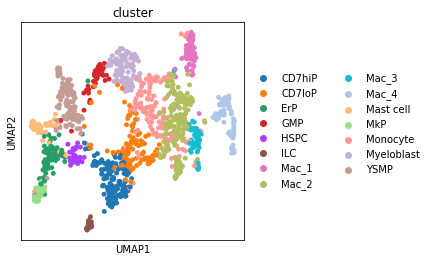

In [21]:
sk.set_figsize((4, 4))
sc.pl.umap(fetal_mac_ad, color="cluster")

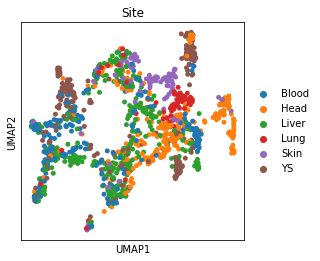

In [22]:
sc.pl.umap(fetal_mac_ad, color="Site")

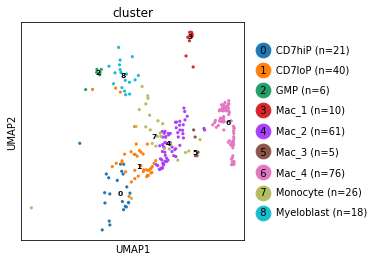

In [15]:
sk.plot_embedding(
    fetal_mac_ad[fetal_mac_ad.obs.Site == "Head"],
    groupby="cluster",
    annot="full",
    min_group_size=3,
    size=40,
);

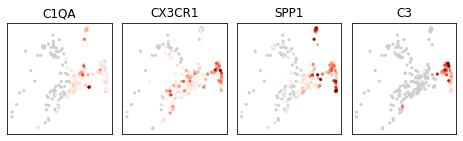

In [20]:
sk.plot_genes(
    fetal_mac_ad[fetal_mac_ad.obs.Site == "Head"], genes=["C1QA", "CX3CR1", "SPP1", "C3"], size=40
);

# Pool

In [23]:
pooled1 = sk.integrate(
    [fetal_skin_ad1, fetal_mac_ad],
    ad_prefices=["fsk", "emb"],
    ad_types=["norm", "counts"],
    annotations=["independent_annotation_refined_20220202", "cluster"],
    batches=["sanger_id", "Site"],
    pool_only=True,
)

In [24]:
pooled1

AnnData object with n_obs × n_vars = 4409 × 19688
    obs: 'batch', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'joint_annotation_20220202', 'annot', 'fig1b_annotation_20220202', 'Stage', 'nGene', 'nUMI', 'dataset'
    var: 'gene_ids-fsk', 'mi

In [25]:
pooled1.var.rename(columns={"cc-fsk": "cc"}, inplace=True)

In [26]:
pooled_ad = sk.simple_default_pipeline(
    pooled1,
    post_norm_only=True,
    batch_method="harmony",
    batch=["dataset", "batch"],
    hvg_kw={"by_batch": ("dataset", 2)},
    pca_kw={"remove_genes": ["mito", "ribo", "cc"]},
    hm_kw={"max_iter_harmony": 30},
)

... storing 'batch' as categorical
... storing 'chemistry' as categorical
... storing 'donor' as categorical
... storing 'gender' as categorical
... storing 'sorting' as categorical
... storing 'sample' as categorical
... storing 'chemistry_sorting' as categorical
... storing 'cell_caller' as categorical
... storing 'independent_annotation_refined' as categorical
... storing 'independent_annotation_broad1' as categorical
... storing 'independent_annotation_broad2' as categorical
... storing 'independent_annotation_broad3' as categorical
... storing 'independent_annotation_broad4' as categorical
... storing 'independent_annotation_broad5' as categorical
... storing 'joint_annotation' as categorical
... storing 'is_maternal' as categorical
... storing 'fig1b_annotation' as categorical
... storing 'independent_annotation_refined_20220201a' as categorical
... storing 'independent_annotation_refined_20220201b' as categorical
... storing 'independent_annotation_broad1_20220201' as categorica

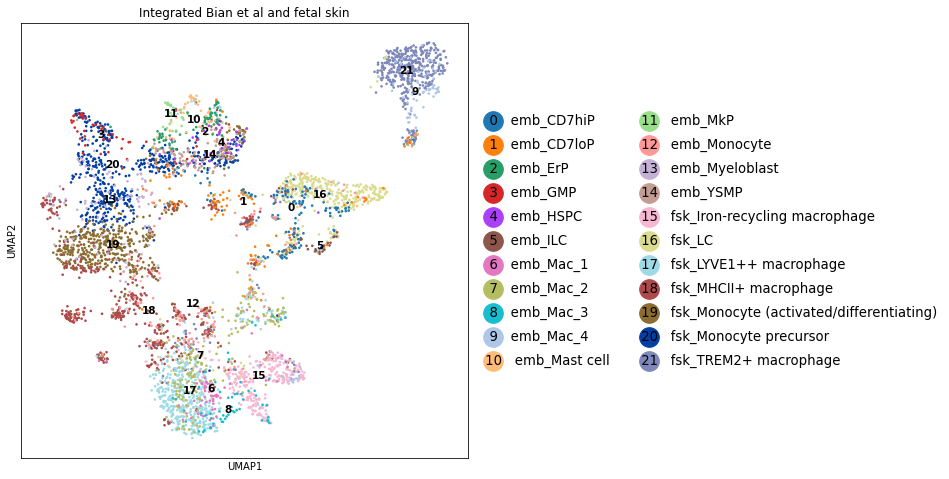

In [27]:
ax = sk.plot_embedding(
    pooled_ad,
    basis="umap_hm",
    groupby="annot",
    figsize=(8, 8),
    legend_fontsize=12,
    title="Integrated Bian et al and fetal skin",
)
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
plt.gcf().savefig("Compare_fetal_skin_macrophages_to_Bian20.umap.pdf", bbox_inches="tight")

Trying to set attribute `.uns` of view, copying.


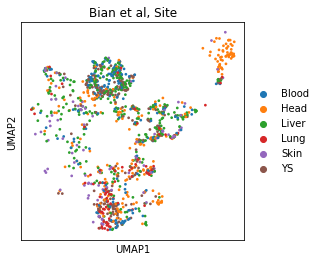

In [28]:
sk.set_figsize((4, 4))
ax = sc.pl.embedding(
    pooled_ad[pooled_ad.obs.dataset == "emb"],
    basis="umap_hm",
    color="batch",
    size=30,
    title="Bian et al, Site",
    show=False,
)
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
plt.gcf().savefig(
    "Compare_fetal_skin_macrophages_to_Bian20.umap_bian20_site.pdf", bbox_inches="tight"
);

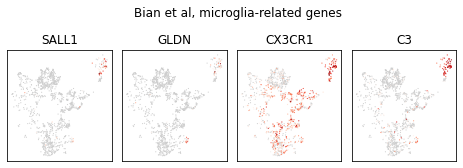

In [29]:
sk.plot_genes(
    pooled_ad[pooled_ad.obs.dataset == "emb"],
    basis="umap_hm",
    genes=["SALL1", "GLDN", "CX3CR1", "C3"],
    size=5,
)
fig = plt.gcf()
fig.suptitle("Bian et al, microglia-related genes", x=0.45, y=1.2)
fig.savefig("Compare_fetal_skin_macrophages_to_Bian20.MG_genes_in_bian20.pdf", bbox_inches="tight")

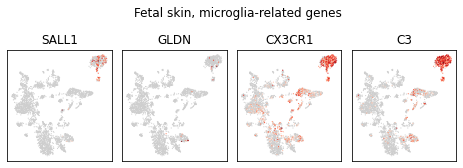

In [39]:
sk.plot_genes(
    pooled_ad[pooled_ad.obs.dataset == "fsk"],
    basis="umap_hm",
    genes=["SALL1", "GLDN", "CX3CR1", "C3"],
    size=5,
)
fig = plt.gcf()
fig.suptitle("Fetal skin, microglia-related genes", x=0.45, y=1.2)
fig.savefig("Compare_fetal_skin_macrophages_to_Bian20.MG_genes_in_fsk.pdf", bbox_inches="tight")

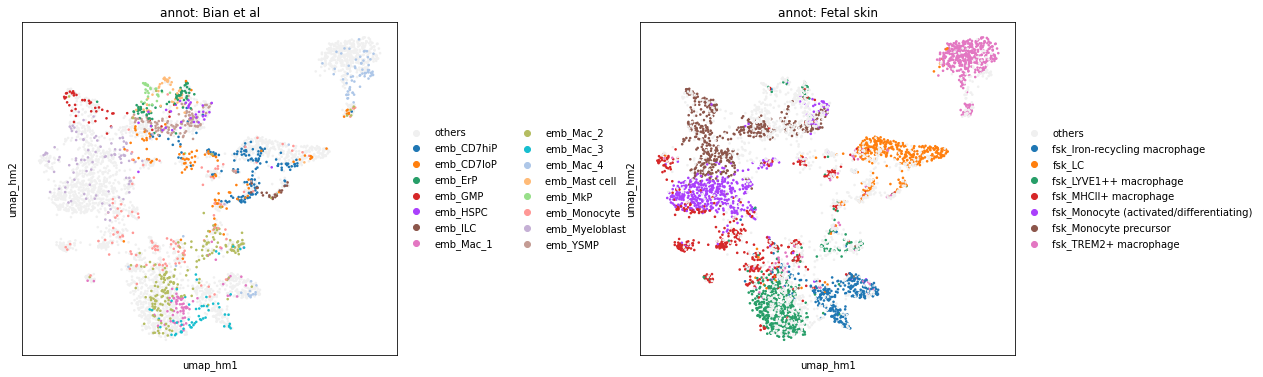

In [31]:
sk.highlight(
    pooled_ad,
    basis="umap_hm",
    groupby="annot",
    prefix_dict={"Bian et al": "emb_", "Fetal skin": "fsk_"},
    figsize=(6, 6),
    wspace=0.5,
);

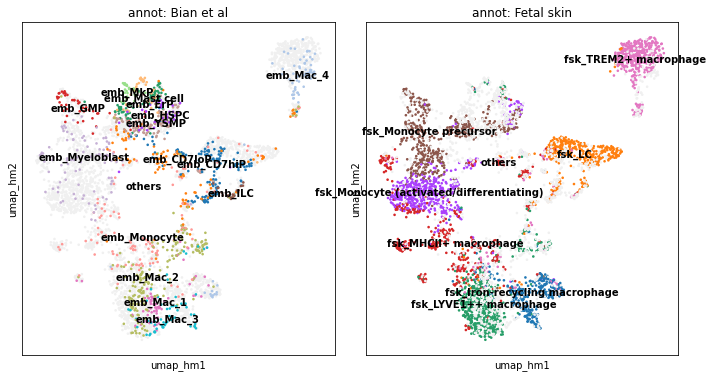

In [32]:
sk.highlight(
    pooled_ad,
    basis="umap_hm",
    groupby="annot",
    prefix_dict={"Bian et al": "emb_", "Fetal skin": "fsk_"},
    figsize=(6, 6),
    legend_loc="on data",
    wspace=0,
);

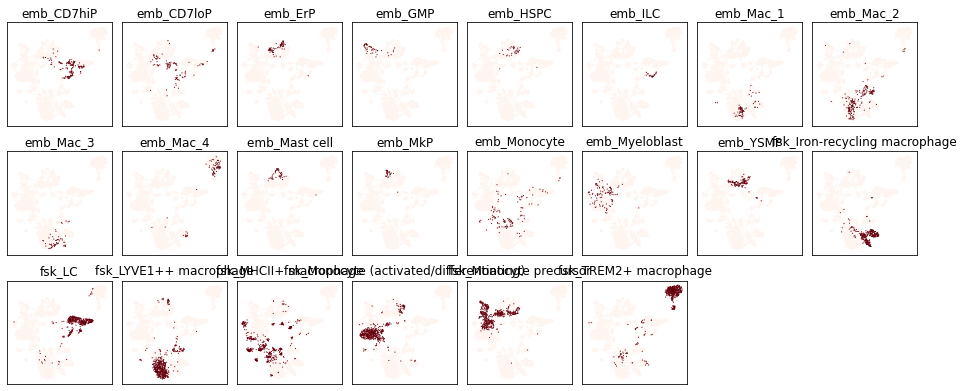

In [33]:
sk.highlight(pooled_ad, basis="umap_hm", groupby="annot", figsize=(2, 2), size=5, ncols=8, wspace=0)

In [58]:
lr = sk.LR_train(fetal_mac_ad, groupby="cluster", use_rep="X", save="bian20_lrnorm.pkl")

In [40]:
sk.LR_predict(myeloid_ad, "bian20_lrnorm.pkl", use_rep="X", key_added="bian20_lr")

19688 features used for prediction


In [139]:
fetal_skin_ad1

AnnData object with n_obs × n_vars = 3178 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'joint_annotation_20220202', 'independent_annotation_refined_20220202', 'fig1b_annotation_20220202', 'bian20_lr', 'bian20_lr_pr

Trying to set attribute `.uns` of view, copying.


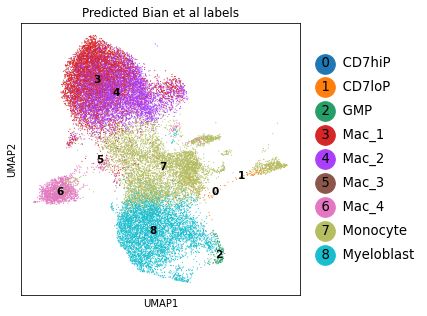

In [41]:
ax = sk.plot_embedding(
    myeloid_ad[myeloid_ad.obs.bian20_lr_prob > 0.3],
    basis="umap_hm",
    groupby="bian20_lr",
    title="Predicted Bian et al labels",
    figsize=(5, 5),
    legend_fontsize=12,
)
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
plt.gcf().savefig("fetal_skin_myeloid.predicted_bian20_labels.pdf", bbox_inches="tight");

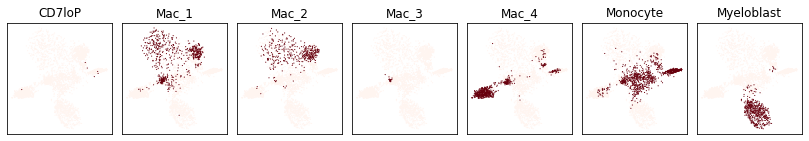

In [34]:
sk.highlight(
    fetal_skin_ad1, basis="umap_hm", groupby="bian20_lr", figsize=(2, 2), size=5, ncols=8, wspace=0
)

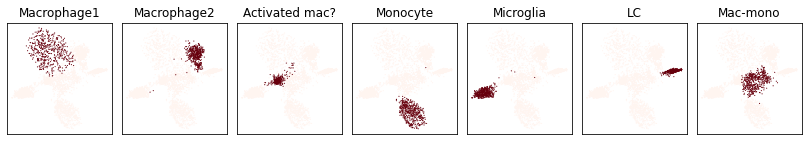

In [35]:
sk.highlight(
    fetal_skin_ad1,
    basis="umap_hm",
    groupby="rachel_annot3",
    figsize=(2, 2),
    size=5,
    ncols=8,
    wspace=0,
)

In [35]:
sk.LR_predict(fetal_skin_ad1, "bian20_lrnorm.pkl", use_rep="X", key_added="bian20_lr")

19688 features used for prediction


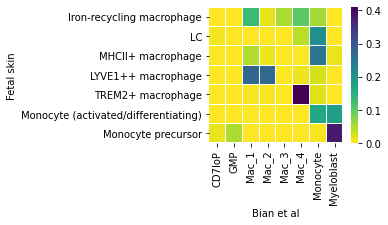

In [36]:
sk.set_figsize((3, 2.5))
ax = sn.heatmap(
    sk.cross_table(fetal_skin_ad1, "independent_annotation_refined_20220202", "bian20_lr", normalise="jaccard"),
    cmap="viridis_r",
    linewidth=0.01,
);
ax.set_xlabel("Bian et al");
ax.set_ylabel("Fetal skin");
plt.gcf().savefig("Compare_fetal_skin_macrophages_to_Bian20.MG_genes_in_bian20.heatmap.pdf", bbox_inches="tight")

In [37]:
pdfs = !ls *.pdf

In [38]:
# for pdf in pdfs:
!rclone copy --drive-shared-with-me --include 'Compare*.pdf' . 'google:/Fetal Skin/Figures/Figs_from_Ni/'

In [42]:
# for pdf in pdfs:
!rclone copy --drive-shared-with-me fetal_skin_myeloid.predicted_bian20_labels.pdf 'google:/Fetal Skin/Figures/Figs_from_Ni/'

In [43]:
pooled_ad.write(
    "compare_fetal_skin_microglial_macrophages_to_embryo_macrophages.h5ad", compression="lzf"
)

In [2]:
ad = sc.read("compare_fetal_skin_microglial_macrophages_to_embryo_macrophages.h5ad")

In [4]:
ad

AnnData object with n_obs × n_vars = 4441 × 18056
    obs: 'n_counts', 'n_genes', 'batch', 'donor', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'annot', 'Stage', 'nGene', 'nUMI', 'dataset'
    var: 'gene_ids-fsk', 'cc-fsk', 'mito', 'ribo', 'hb', 'n_counts', 'n_cells'